## Barcelona geojson files:

On the way to wondering how to create a map of the middle kingdom for Islamic history I also got thinking about creating a personalized Barcelona map. Turns out there are compete geojson files for Barca which are in the included folder.

This [website](https://docs.astraea.earth/hc/en-us/articles/360043919911-Read-a-GeoJSON-File-into-a-GeoPandas-DataFrame) offers some guidance for reading such files into a geopandas data frame. Let's see if it works.

[Geopandas Reference:](https://geopandas.org/en/stable/index.html)

[Shapely LineString Class:](https://shapely.readthedocs.io/en/stable/manual.html) It would appear that the Shapely Point objects and Polygon objects I have met so far also offer LineString as a 1 dimensional object that could be used for street maps. Just linking this here as future reference as I try to develop a street map of Barcleona

In [3]:
import geopandas as gpd
import geoplot as gp
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from IPython.display import display, Image
from shapely.geometry import Point

### Global Geopandas Data Sources

The datasets given below are broadly available for general use. Seems potentially useful for drawing low res maps of the world.

In [4]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

### Barcelona Geojson Data Sets

The bcn-geodata contains a multitude of geographic data sets in geojson format. The 2020 data was imported from [this github](https://github.com/martgnz/bcn-geodata). 

A range of other data is available on the [Barcelona municipal open data site](https://opendata-ajuntament.barcelona.cat/en/) which seems like an AWESOME resource. This is the [mapping article](https://diegoquintanav.github.io/folium-barcelona-EN.html) that got me turned on to the data. Need to explore more for sure.

I had some difficulty understanding what was inside the .geojson file so I opened it to take a look. The screen shot below gives a sense. Notice the 'NOM' field which has the name of the barri which I wanted. On the other hand it doesn't show in the 

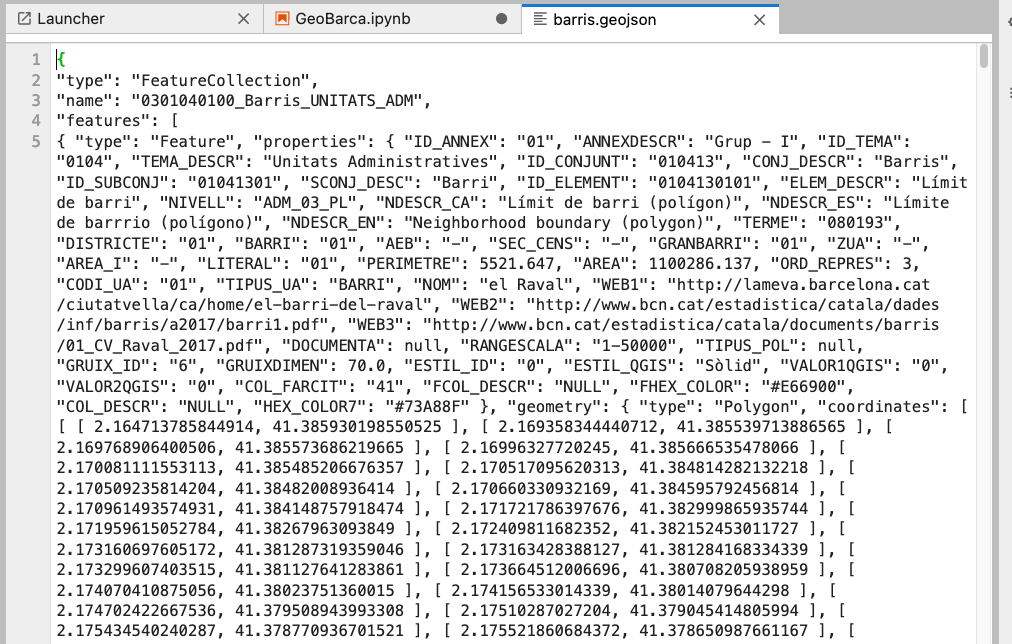

In [5]:
Image('images/barcaGeojsonFormat.png')

Next two cells read some data in from the database and then print out the .crs (coordinate reference systems) for the dataframe and the type of dataframe to be sure everything is on track.

* districtes -- the broad districts
* barris -- the idividual barri
* censal -- these appear to be the census tracts
* terme -- outer boundary of Barca
* estadistica - statistics but by different tracts than any of above
* interes - looks like the airport/port/olimpico part of the city
* urban -- yet another subdivision of the city. Seems like two polygons in each barri?

In [33]:
barcaDFdistrictes = gpd.read_file("bcn-geodata/districtes/districtes.geojson")
barcaDFbarris = gpd.read_file("bcn-geodata/barris/barris.geojson")
barcaDFcensal = gpd.read_file("bcn-geodata/seccio-censal/seccio-censal.geojson")
barcaDFterme = gpd.read_file("bcn-geodata/terme-municipal/terme-municipal.geojson")
barcaDFestadistica = gpd.read_file("bcn-geodata/area-estadistica-basica/area-estadistica-basica.geojson")
barcaDFinteres = gpd.read_file("bcn-geodata/area-interes/area-interes.geojson")
barcaDFurban = gpd.read_file("bcn-geodata/zona-urban-audit/zona-urban-audit.geojson")

### Identify Data Type:

Just a quick check to be sure that I know the data type and reference system for the data. The open data from Barcelona seems to be in the [EPSG:4326](https://epsg.io/4326) system

In [34]:
#print("Districts: \n",(barcaDFdistrictes.crs,type(barcaDFdistrictes)))
#print("\n Barri: \n", (barcaDFbarris.crs,type(barcaDFbarris)))
#print("\n censal: \n", (barcaDFcensal.crs, type(barcaDFcensal)))
#print("\n terme: \n", (barcaDFterme.crs, type(barcaDFterme)))
#print("\n estadistica: \n", (barcaDFestadistica.crs, type(barcaDFestadistica)))
#print("\n interes: \n", (barcaDFinteres.crs, type(barcaDFinteres)))
print("\n urban audit: \n", (barcaDFurban.crs, type(barcaDFurban)))


 urban audit: 
 (<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, <class 'geopandas.geodataframe.GeoDataFrame'>)


### Display the Dataframe

I often forget whats in these data frames so it's helpful sometimes to roll it out to see what the formatting is. 

In [25]:
barcaDFestadistica.columns

Index(['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT',
       'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR',
       'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'TERME', 'DISTRICTE',
       'BARRI', 'AEB', 'SEC_CENS', 'GRANBARRI', 'ZUA', 'AREA_I', 'LITERAL',
       'PERIMETRE', 'AREA', 'ORD_REPRES', 'CODI_UA', 'TIPUS_UA', 'NOM', 'WEB1',
       'WEB2', 'WEB3', 'DOCUMENTA', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID',
       'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_QGIS', 'VALOR1QGIS', 'VALOR2QGIS',
       'COL_FARCIT', 'FCOL_DESCR', 'FHEX_COLOR', 'COL_DESCR', 'HEX_COLOR7',
       'geometry'],
      dtype='object')

In [27]:
barcaDFestadistica["SEC_CENS"]

0      -
1      -
2      -
3      -
4      -
      ..
228    -
229    -
230    -
231    -
232    -
Name: SEC_CENS, Length: 233, dtype: object

### ..and then there's plotting!

So much to figure out here and comment. Much learning happening - yikes!

To control the density of the facecolor differently than the density of the edgecolor a stackexchange thread suggested using colorConverter to define a face color WITH the alpha already packaged in. Note that I needed to import the colorConverter library to do this.

Realized that the plot is built up in layers so the order in which I display the layers affects which color is laid on top of the other. Thoughtful choices seem important here.

**Questions:** 

* How do I identify the names of the specific regions. The names don't appear to be in the dataframe -- opening up the geojson file indicated that there 

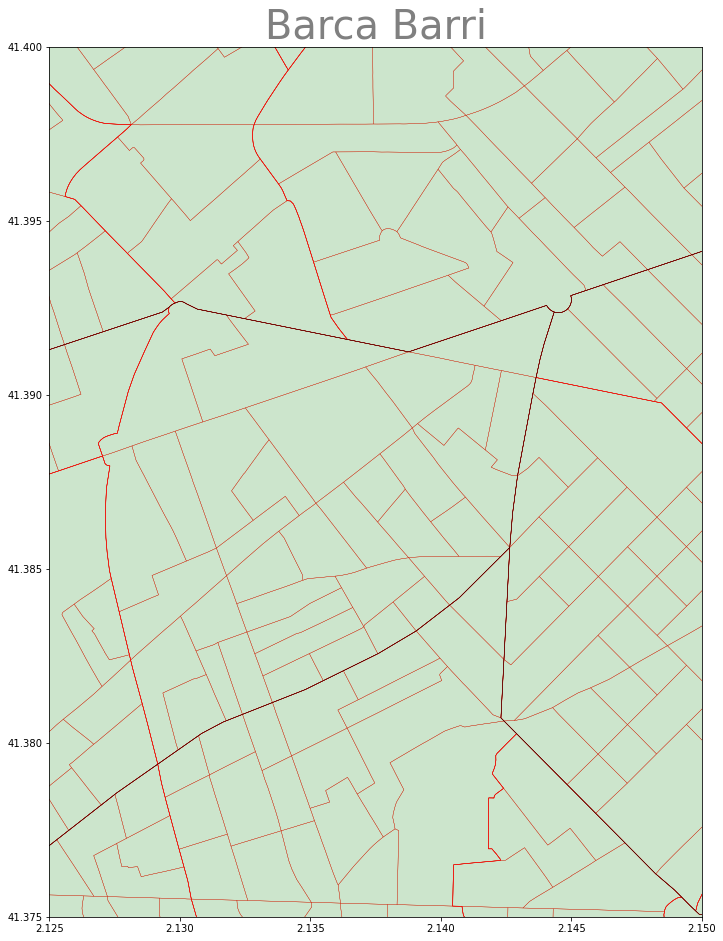

In [7]:
fig, ax = plt.subplots(figsize=(16,16))

fc1 = colorConverter.to_rgba('green', alpha=0.2)
fc2 = colorConverter.to_rgba('green', alpha=0.2)

barcaDFcensal.plot(ax=ax, facecolor = 'none', edgecolor = 'red', linewidth=0.3) 
barcaDFbarris.plot(ax=ax,facecolor = fc1, edgecolor='red', linewidth=0.5) 
barcaDFdistrictes.plot(ax=ax, facecolor = 'none',edgecolor='k', linewidth=0.3) 

#barcaDFbarris.plot(ax=ax, facecolor = 'whitesmoke', edgecolor='darkgrey', linewidth=0.3) 

plt.title("Barca Barri", fontsize=40, color='grey')
plt.xlim(2.125, 2.150)
plt.ylim(41.375, 41.400)
#plt.axis('equal')

plt.show()

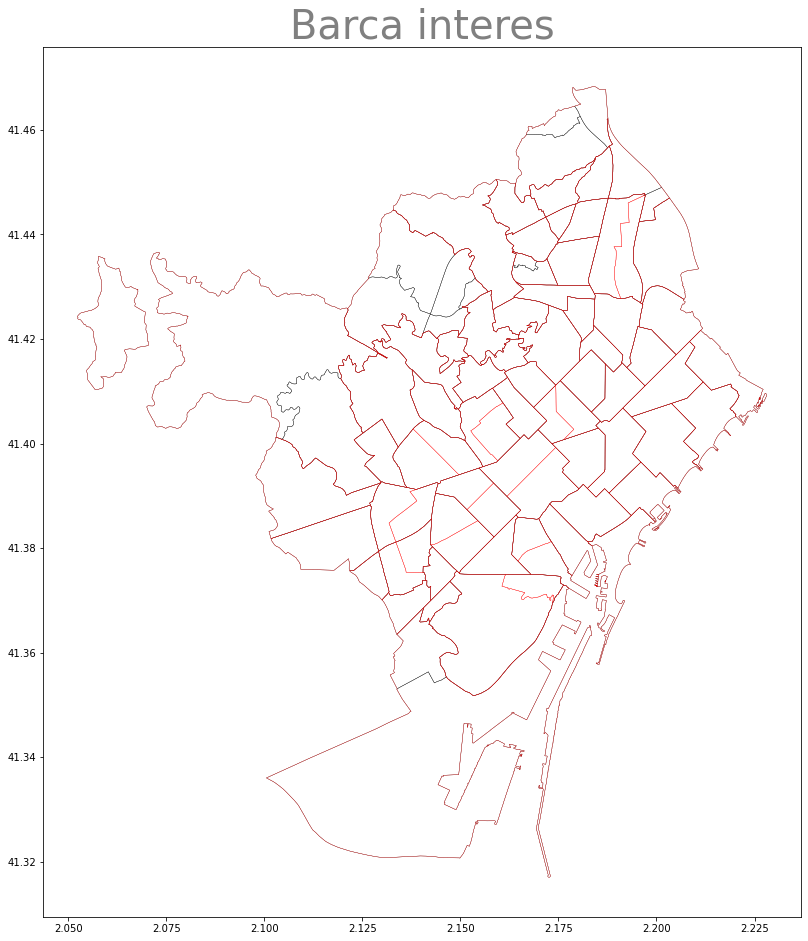

In [38]:
fig2, ax2 = plt.subplots(figsize=(16,16))

fc1 = colorConverter.to_rgba('green', alpha=0.2)

#barcaDFestadistica.plot(ax=ax2, facecolor = 'none', edgecolor = 'b', linewidth=0.3) 
#barcaDFinteres.plot(ax=ax2, facecolor = 'none',edgecolor='r', linewidth=0.3) 
#barcaDFbarris.plot(ax=ax2, facecolor = 'none',edgecolor='k', linewidth=0.3) 
#barcaDFcensal.plot(ax=ax2, facecolor = 'none',edgecolor='b', linewidth=0.3) 
#barcaDFdistrictes.plot(ax=ax2, facecolor = 'none',edgecolor='k', linewidth=0.3) 
barcaDFurban.plot(ax=ax2, facecolor = 'none',edgecolor='r', linewidth=0.3) 


plt.title("Barca interes", fontsize=40, color='grey')
#plt.xlim(2.125, 2.150)
#plt.ylim(41.375, 41.400)
#plt.axis('equal')

plt.show()